In [1]:
import numpy as np
import random
import csv
import time
import math

from matplotlib import pyplot as plt

# from edtDist import editDistanceString

In [2]:
def EditDist(str1, str2):
    len1 = len(str1)
    len2 = len(str2)
    
    res = 0
 
    # Create a DP array to memoize result
    # of previous computations
    DP = [[0 for i in range(len1 + 1)]
             for j in range(2)];
 
    # Base condition when second String
    # is empty then we remove all characters
    for i in range(0, len1 + 1):
        DP[0][i] = i
 
    # Start filling the DP
    # This loop run for every
    # character in second String
    for i in range(1, len2 + 1):
         
        # This loop compares the char from
        # second String with first String
        # characters
        for j in range(0, len1 + 1):
 
            # If first String is empty then
            # we have to perform add character
            # operation to get second String
            if (j == 0):
                DP[i % 2][j] = i
 
            # If character from both String
            # is same then we do not perform any
            # operation . here i % 2 is for bound
            # the row number.
            elif(str1[j - 1] == str2[i-1]):
                DP[i % 2][j] = DP[(i - 1) % 2][j - 1]
             
            # If character from both String is
            # not same then we take the minimum
            # from three specified operation
            else:
                DP[i % 2][j] = (1 + min(DP[(i - 1) % 2][j],
                                    min(DP[i % 2][j - 1],
                                  DP[(i - 1) % 2][j - 1])))
             
    # After complete fill the DP array
    # if the len2 is even then we end
    # up in the 0th row else we end up
    # in the 1th row so we take len2 % 2
    # to get row
    res = DP[len2 % 2][len1]
    
    return res

In [3]:
def editDistance(list1, list2):
    string1 = ""
    string2 = ""
    for i in list1:
        string1 += str(i)
    for i in list2:
        string2 += str(i)
    
    dist = EditDist(string1, string2)
    
    return dist

In [4]:
print(editDistance([0,0,0,0],[1,1,0,1]))

3


# Approximate Trace Reconstruction(Warmup Algorithms)

# Warmup Algorithm 1

The first algorithm εn-approximately reconstructs a string with long runs using $Ω(log(n)/ε^{2})$ traces by scaling an average of the run length across all traces.

**Proposition:** *Let X be a string on n bits such that all of its runs have length at least $log(n^{5})$. Then X can be εn-approximately reconstructed with $O(log(n)/ε{2})$ traces.*

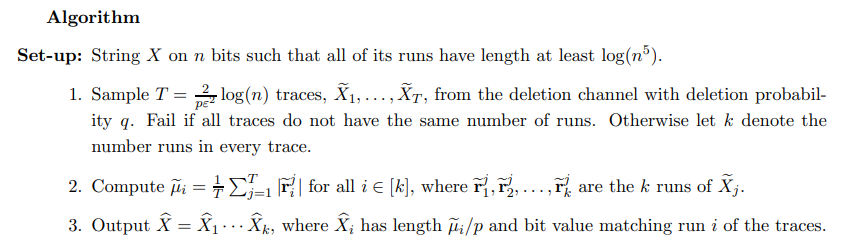

In [5]:
def runCounter(receivedArray):
    noOfStrings, length = receivedArray.shape
    
    k = 1
    bit = receivedArray[0][0]
    temp = [bit]
    for i in range(1,length):
        if(bit != receivedArray[0][i]):
            k += 1
            bit = receivedArray[0][i]
            temp.append(bit)
            
    return k, temp

In [6]:
def warmup1(receivedArray, p):
    noOfStrings, length = receivedArray.shape
    k,bitString = runCounter(receivedArray)
    
    temp = np.zeros((noOfStrings, k+1), dtype=int)
    
    for i in range(noOfStrings):
        count = 1
        b = 0
        bit = receivedArray[i][0]
        for j in range(1,length):
            if(receivedArray[i][j] == bit):
                count += 1
                bit = receivedArray[i][j]
            else:
                temp[i][b] = count
                count = 1
                b += 1
                bit = receivedArray[i][j]
        temp[i][b] = count
    
    average = []
    for b in range(k):
        total = 0
        for i in range(noOfStrings):
            total += temp[i][b]
        avg = round(total/(noOfStrings*p))
        average.append(avg)
    
    res = []
    for b in range(k):
        if(bitString[b] != -1):
            temp = [bitString[b]]*average[b]
            res.extend(temp)
    
    
    return res

**Note**: *There is no rounding mentioned in the algorithm of the code. Rounding is used, since we need to arrive at an integer.*

In [7]:
#For Testing

print(warmup1(np.array([[1,1,0,0,1],[1,0,0,0,1],[1,1,1,0,1]]),1))

[1, 1, 0, 0, 1]


# Dataset Generation

In this portion, we will generate the dataset for running the **Warmup Algorithm 1** on. The code will take length of string, sampling parameters(p, ε) , and probability of deletion and give out a random binary string, and also a matrix containing the transmitted strings.

There are some conditions that the dataset must satisfy.

 - All the runs must have a length of at least $log(n^{5})$.
 - The number of runs in all of the traces must be equal

In [8]:
def originString(length,q):
    temp = []
    tmp = 0
    a = round(math.log(length**5,(1/q)))
    bit = random.randint(0,1)
    
    while(len(temp) < length):
        bit = 1-bit
        lng = random.randint(a,2*a)
        if((len(temp) + lng) > length):
            break
        temp1 = [bit]*lng
        temp.extend(temp1)
    
    if(length-len(temp)>a):
        temp1 = [bit]*(length-len(temp))
        temp.extend(temp1)
        return temp,1
    else:
        return temp,0

In [9]:
def createDataSet(length, prob, _epsilon):
    q = prob/100
    p = 1-q
    noOfTransmissions = round((2 * math.log(length,(1/q))) /(p*_epsilon*_epsilon))
    
    matrix = np.zeros((noOfTransmissions,length),dtype=int)
    
    tmp = 0
    
    while(tmp != 1):
        temp, tmp = originString(length,q)
    transmittedString = np.array(temp)
    temp = np.array([temp])
    
    runsm, _ = runCounter(temp)
    
    k = 0
    while(k < noOfTransmissions):
        temp = [-1]*length
        j = 0
        for i in range(length):
            a = random.choices([0,1], weights=(prob,100-prob), k=1)
            if(a == [0]):
                continue
            else:
                temp[j] = transmittedString[i]
                j += 1
        temp = np.array([temp])
        runs, _ = runCounter(temp)
        if(runs-1 == runsm or runs == runsm):
            matrix[k] = temp
            k += 1
            
    return transmittedString, matrix, p, runs

(array([ 10.,   0.,   0.,   0.,   0.,  96.,   0.,   0.,   0.,   0., 289.,
          0.,   0.,   0.,   0., 385.,   0.,   0.,   0.,   0., 177.,   0.,
          0.,   0.,   0.,  40.,   0.,   0.,   0.,   3.]),
 array([23. , 23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. ,
        25.2, 25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2,
        27.4, 27.6, 27.8, 28. , 28.2, 28.4, 28.6, 28.8, 29. ]),
 <BarContainer object of 30 artists>)

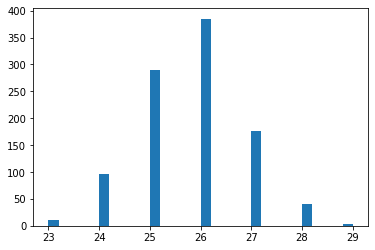

In [10]:
t = []
for i in range(1000):
    _,_,_,m  = createDataSet(480, 10,1)
    t.append(m)

t = np.array(t)
plt.hist(t, bins='auto')

The dataset generation conditions bring up another set of conditions that have to be applied to make sure that the original string is realistic and fast.

 - Each run is restricted not only on the lower side $log(n^{5})$, but also by $2 \times log(n^{5})$ on the upper side
 - The minimum length of the total string has to be 40, as the number of runs is less than 5 for length of string below 40.

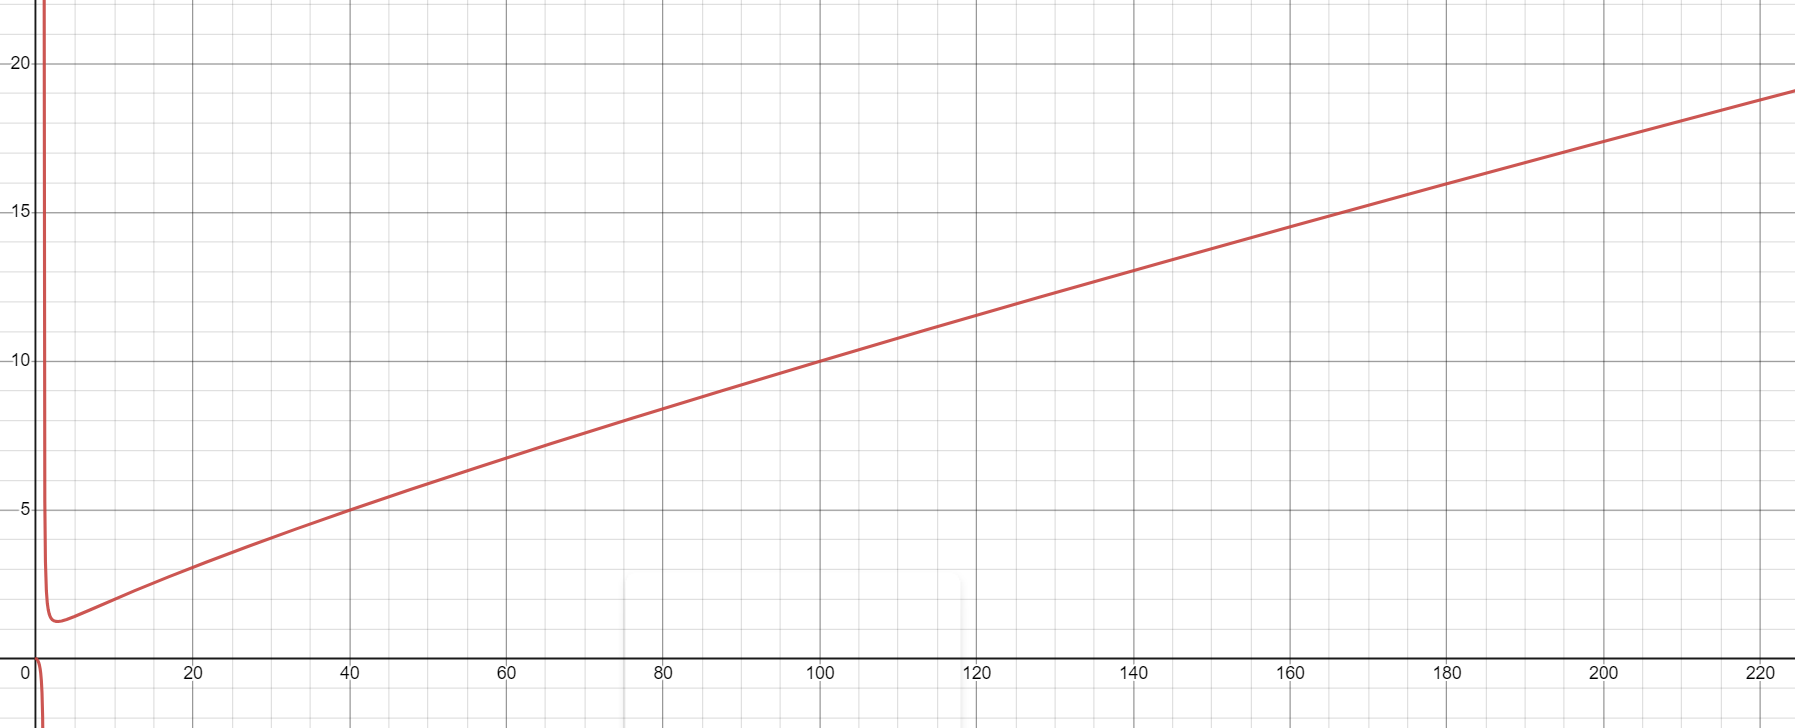

No of Runs v/s Length, assuming all runs are of length round($log(n^{5})$).

In [11]:
#For Testing

transmittedString, matrix, p, runs = createDataSet(40,1,0.1)
print(transmittedString,len(transmittedString))

lis = []
a = transmittedString[0]
count = 0
for i in transmittedString:
    if(a == i):
        count += 1
        a = i
    else:
        print(count)
        count = 1
        a = i

calcStr = np.array(warmup1(matrix,p))
print(calcStr,len(calcStr))



np.array_equal(transmittedString, calcStr)

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0] 40
8
7
6
8
6
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0] 40


True

# Validation of the Algorithms

In [12]:
# probs = [0.1,0.3,1.0,3.0,10.0]

# file = 'Warmup_#1_Corrected.csv' 

# header = ['Length','Deletion Probability','Percentage Error', 'Time Taken']

# with open(file, 'w',newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(header)
#     for lens in range(40,1000,40):
#         for prob in probs:
#             correct = 0
#             start = time.time()
#             for i in range(1000):
#                 transmittedString, matrix, p, runs = createDataSet(lens,prob,0.5)
#                 calcStr = np.array(warmup1(matrix,p))
#                 if(np.array_equal(transmittedString, calcStr)):
#                     correct += 1
#             end = time.time()
#             per = round(100-((correct*100)/1000),2)
#             tt = end-start
            
#             temp = [lens, prob, per, tt]
#             print(temp)
#             csvwriter.writerow(temp)

The success rate is quite nice, but the only limitations are those imposed by the properties of the input binary string. Nevertheless, we can compare between BMA and Warmup Algo #1. Note that the same number of transmits or traces will be provided to the algo in both cases.

In [13]:
def bma(receivedStringArray):
    noOfStrings, length = receivedStringArray.shape
    
    c = np.zeros(noOfStrings,dtype=int)
    transmittedString = np.zeros(length,dtype=int)
    
    for i in range(length):
        temp = [0,0]
        for j in range(noOfStrings):
            tmp = receivedStringArray[j,c[j]]
            temp[tmp] += 1
        index_max = np.argmax(temp)
        transmittedString[i] = index_max  
        
        for j in range(noOfStrings):
            if receivedStringArray[j,c[j]] == transmittedString[i]:
                c[j] += 1
            else:
                continue
            
                  

    return transmittedString

In [14]:
#For Testing

transmittedString, matrix, p, runs = createDataSet(480,2,1)
matrixBMA = matrix.copy()
matrix[matrix==-1]=0
calculatedString = bma(np.array(matrix))

print(transmittedString)
print(calculatedString)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
probs = [0.1,0.3,0.5,1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10.0]
epsilons = [0.1,0.3,0.5,1.0]

file = 'Comparison_New.csv' 

header = ['Length','Deletion Probability', 'Epsilon', '%Error_in_BMA', 'Time Taken_in_BMA', 'Average_EditDistance_BMA', '%Error_in_WA1', 'Time Taken_in_WA1', 'Average_EditDistance_WA1']

with open(file, 'w',newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(header)
    for lens in range(180,301,20):
        print("Completed")
        for prob in probs:
            for epsilon in epsilons:
                masterTime1 = 0
                masterTime2 = 0
                ed1 = 0
                ed2 = 0
                correct1 = 0
                correct2 = 0
                for i in range(1000):                
                    transmittedString, matrix, p, runs = createDataSet(lens,prob,epsilon)

                    #BMA

                    matrixBMA = matrix.copy()
                    matrixBMA[matrixBMA==-1]=0
                    start1 = time.time()
                    calculatedString = bma(np.array(matrixBMA))
                    end1 = time.time()
                    ed1 += editDistance(list(transmittedString), list(calculatedString))
                    if(str(transmittedString) == str(calculatedString)):
                        correct1 += 1

                    masterTime1 += (end1-start1)                

                    #WA1
                    start2 = time.time()
                    calcStr = np.array(warmup1(matrix,p))
                    end2 = time.time()
                    ed2 += editDistance(list(transmittedString), list(calcStr))
                    if(np.array_equal(transmittedString, calcStr)):
                        correct2 += 1

                    masterTime2 += (end2-start2)

                per1 = 100 - round((correct1/10),2)
                ed1 = ed1/1000
                per2 = 100 - round((correct2/10),2)
                ed2 = ed2/1000
                temp = [lens, prob, epsilon, per1, masterTime1, ed1, per2, masterTime2, ed2]
                print(temp)
                csvwriter.writerow(temp)

Completed
[180, 0.1, 0.1, 0.0, 22.49951410293579, 0.0, 0.0, 14.717473030090332, 0.0]
[180, 0.1, 0.3, 0.0, 3.418745279312134, 0.0, 0.0, 1.8614981174468994, 0.0]
[180, 0.1, 0.5, 0.0, 1.8936665058135986, 0.0, 0.0, 0.8660635948181152, 0.0]
[180, 0.1, 1.0, 16.599999999999994, 1.1120920181274414, 5.497, 0.20000000000000284, 0.3651587963104248, 0.002]
[180, 0.3, 0.1, 0.0, 26.09402060508728, 0.0, 0.0, 17.176241636276245, 0.0]
[180, 0.3, 0.3, 0.0, 3.7463274002075195, 0.0, 0.0, 2.171903371810913, 0.0]
[180, 0.3, 0.5, 0.0, 1.8854315280914307, 0.0, 0.0, 0.9059996604919434, 0.0]
[180, 0.3, 1.0, 43.7, 1.077286720275879, 12.88, 2.0999999999999943, 0.3574559688568115, 0.021]
[180, 0.5, 0.1, 0.0, 27.54764699935913, 0.0, 0.0, 17.869114637374878, 0.0]
[180, 0.5, 0.3, 0.0, 4.026154279708862, 0.0, 0.0, 2.300549030303955, 0.0]
[180, 0.5, 0.5, 0.09999999999999432, 1.9278488159179688, 0.018, 0.0, 0.9009363651275635, 0.0]
[180, 0.5, 1.0, 59.2, 1.0335087776184082, 18.459, 7.0, 0.3332803249359131, 0.075]
[180, 1

[200, 5.0, 0.1, 100.0, 63.54661417007446, 50.323, 0.0, 42.37840223312378, 0.0]
[200, 5.0, 0.3, 100.0, 8.652041673660278, 48.036, 1.0, 5.326932191848755, 0.01]
[200, 5.0, 0.5, 100.0, 4.55324387550354, 44.624, 31.099999999999994, 2.3599977493286133, 0.345]
[200, 5.0, 1.0, 100.0, 2.1000208854675293, 47.512, 97.8, 0.7167577743530273, 3.05]
